# 判别分析

分类问题是机器学习的经典问题，这个问题在多元统计的经典形式就是判别分析，其基本都依赖了概率结构。
虽然在机器学习算法眼里都是非常虚弱而且假设过强的算法。

判别分析将分类看成一个总体，对于一个给定样本，尝试根据某些规则判定其来自哪个总体。这个总体一般建模为某个多元正态分布。
样本是$p$维向量，在机器学习眼里看来是$p$个特征。判别分析认为期望与各个特征的协方差矩阵，与多元正态分布的结构足以刻画一个类的属性。
然后把分类问题转化为问这个样本设为是哪个总体生成的最靠谱，并以此为结论。这个在稍微复杂一点的情况下就不靠谱了。
当然无论如何，起码可以作为某个基线。

## 距离判别

既然用了多元正态分布总体刻画类，最自然的距离就是综合了各维“标准化违抗度”的马氏距离，

$$
(X - \mu)^T \Sigma^{-1} (X - \mu)
$$

我们知道这个东西在假设的确成立时服从$\chi^2(p)$分布。而不成立时会偏向更大，这正是我们要的性质，可以看成类似那种类置信区间的，
从假设检验里反推出的东西。

那么我们可以拿已知分类的数据，一堆标记了类型的p维向量各自估计它们的总体。来新的数据再计算对其的各个距离，取距离最小者为我们的判别结果。
当然如果没有“最小”，即不存在一类它的距离比其他类的严格小，则视为“待判”，如果一定要判可以在最小距离集合里随机选一个。

这个方法在总体不服从正态分布时也有意义，当然正态分布时两阶矩就控制了所有信息，其他分布就不一定了。

In [208]:
library(klaR)

In [209]:
library(MASS)

## 贝叶斯判别

贝叶斯判别就是把样本直接代入总体的密度函数，看似然度。这个可以加上先验概率校准（即使对各个分类得到相同的值），这样就可以凑成严格的贝叶斯形式。

$$
P(B_i|A) = \frac{P(A|B_i)P(B_i)}{{\sum_{j=1}^k P(A|B_j)P(B_j)}}
$$

其中$A$表示出现给定样本这个事件，$B_i$是样本属于$i$类的概率。我们所知道的是

$$
P(A|B_i) = f(x_0;\mu_i,\Sigma_i)
$$

为样本$x_0$出现在$i$类对应的多元正态分布总体的似然度。先验概率$P(B_i)$不适合用占训练集的比例估计，
显然那样多加一些特定类样本把估计精确化居然会影响先验分布。如果不把训练集看成某种超总体抽样，就应该与其无关的设定先验概率，
比如全部设成一样的直接消掉这个项。

参数取$(\mu,\Sigma)$的多元正态分布的密度分布函数为

$$
f(X;\mu,\Sigma) = \frac{1}{(2\pi)^{p/2}|\Sigma|^{1/2}} exp\left( -\frac{1}{2} (x - \mu)^T \Sigma^{-1} (x - \mu) \right)
$$

In [210]:
rcov <- function(n, r, Lam=NULL){
    if(is.null(Lam)){
        lam <- rep(0,n)
        lam[1:r] <- runif(r,0.5,1.5)
        Lam <- diag(lam)
    }
    A <- matrix(runif(n*n,-2,2),n)
    return(t(A) %*% Lam %*% A)
}

rmultinorm <- function(n,mu,Sigma){
    res <- eigen(Sigma)
    Lambda <- diag(res$values)
    P <- res$vectors
    r <- replicate(n,as.vector( P %*% Lambda^(1/2) %*% rnorm(length(mu))) + mu)
    return(r)
}

pTsq <- function(x, p, n, lower.tail=TRUE){
    pf((n-p+1)/(p*n) * x, p, n-p+1, lower.tail = lower.tail)
}

qTsq <- function(x, p, n, lower.tail=TRUE){
    y <- qf(x, p, n-p+1, lower.tail = lower.tail)
    return((p*n)/(n-p+1) * y)
}

decomp <- function(X,group){
    # X is (p,n) matrix, group is n dimention vector
    Xbar <- NULL
    for(g in unique(group)){
        index <- group == g
        ni <- sum(index)
        #Xbari <- mean(X[,index],1)
        Xbari <- apply(X[,index],1,mean)
        Xbar <- cbind(Xbar, matrix(rep(Xbari,ni),nrow(X)))
    }
    #Xbarbar <- matrix(rep(mean(X,1),ncol(X)),nrow(X))
    Xbarbar <- matrix(rep(apply(X,1,mean),ncol(X)),nrow(X))
    B <- (Xbar - Xbarbar) %*% t(Xbar - Xbarbar)
    E <- (X - Xbar) %*% t(X - Xbar)
    W <- (X - Xbarbar) %*% t(X - Xbarbar)
    return(list(B = B, E = E, W = W))
}



In [211]:
dmultinorm <- function(x, mu, sigma){
    p <- length(mu)
    coe <- 1/( (2*pi)^(p/2) * sqrt(det(sigma)) )
    power <- -1/2 * t(x - mu) %*% solve(sigma) %*% (x-mu)
    return( coe * exp(power))
}

In [212]:
Sigma <- rcov(5,5)
Sigma

6.4820342,-1.82517073,4.834666,-4.17773760,0.3791943
-1.8251707,3.54742021,-1.716157,0.08646848,2.6174671
4.8346656,-1.71615741,7.941692,-1.27622487,-1.6590497
-4.1777376,0.08646848,-1.276225,5.69160465,-2.0025422
0.3791943,2.61746715,-1.659050,-2.00254222,3.9769276


In [213]:
mu <- rep(0,5)
mu

[1] 0 0 0 0 0

In [214]:
dmultinorm(c(0,0,0,0,0),mu,Sigma)

0.0008423307


In [215]:
dmultinorm(c(1,2,3,4,5),mu,Sigma)

5.352016e-11


结果与python的`scipy.stats.multivariate_normal.pdf`一致，验证了其正确性。

## Fisher判别

对于k个类共$n = \sum_i^k n_i$个样本。向量经过一个$p$维列向量$a$线性投影$a^T x$后后变为单变量。我们想寻求一个这样的的$a$，
其使得单变量方差检验的统计量$F$，最大化。显然这意味着$H_0$，即各总体均值相同的假设显得越假，
也就是这个$a$的投影使得各总体在此投影下最分散开（通过均值）。

$$
F = \frac{SSA / (k-1)}{SSE/(n-k)} = \frac{n-k}{k-1}\frac{a^T B a}{a^T E a}
$$

其中$a$是投影向量，这里的$B,E$就是之前满足分解$W = B + E$的组间离差阵和组内离差阵。

抛掉在优化过程中固定的常数,我们就是控制$a$来最大化

$$
\max_a \frac{a^T B a}{a^T E a}
$$

可以证明

$$
W^{-1}B = (B + E)^{-1}B
$$

的前几个特征向量就是前几优的$a$，但特征值是$\frac{a^T B a}{a^T W a}$的最优值（两个分式的最优$a$是一样的。）
而不是$\frac{a^T B a}{a^T E a}$的。（《实用多元统计》P513）。

In [216]:
head(iris)

Sepal.Length,Sepal.Width,Petal.Length,Petal.Width,Species
5.1,3.5,1.4,0.2,setosa
4.9,3.0,1.4,0.2,setosa
4.7,3.2,1.3,0.2,setosa
4.6,3.1,1.5,0.2,setosa
5.0,3.6,1.4,0.2,setosa
5.4,3.9,1.7,0.4,setosa


In [217]:
X <- t(as.matrix(iris[,-ncol(iris)]))

In [218]:
X

Sepal.Length,5.1,4.9,4.7,4.6,5.0,5.4,4.6,5.0,4.4,4.9,...,6.7,6.9,5.8,6.8,6.7,6.7,6.3,6.5,6.2,5.9
Sepal.Width,3.5,3.0,3.2,3.1,3.6,3.9,3.4,3.4,2.9,3.1,...,3.1,3.1,2.7,3.2,3.3,3.0,2.5,3.0,3.4,3.0
Petal.Length,1.4,1.4,1.3,1.5,1.4,1.7,1.4,1.5,1.4,1.5,...,5.6,5.1,5.1,5.9,5.7,5.2,5.0,5.2,5.4,5.1
Petal.Width,0.2,0.2,0.2,0.2,0.2,0.4,0.3,0.2,0.2,0.1,...,2.4,2.3,1.9,2.3,2.5,2.3,1.9,2.0,2.3,1.8


In [219]:
group <- iris$Species

In [220]:
group

[1] setosa     setosa     setosa     setosa     setosa     setosa    
  [7] setosa     setosa     setosa     setosa     setosa     setosa    
 [13] setosa     setosa     setosa     setosa     setosa     setosa    
 [19] setosa     setosa     setosa     setosa     setosa     setosa    
 [25] setosa     setosa     setosa     setosa     setosa     setosa    
 [31] setosa     setosa     setosa     setosa     setosa     setosa    
 [37] setosa     setosa     setosa     setosa     setosa     setosa    
 [43] setosa     setosa     setosa     setosa     setosa     setosa    
 [49] setosa     setosa     versicolor versicolor versicolor versicolor
 [55] versicolor versicolor versicolor versicolor versicolor versicolor
 [61] versicolor versicolor versicolor versicolor versicolor versicolor
 [67] versicolor versicolor versicolor versicolor versicolor versicolor
 [73] versicolor versicolor versicolor versicolor versicolor versicolor
 [79] versicolor versicolor versicolor versicolor versicolor versicolor
 [85] versicolor versicolor versicolor versicolor versicolor versicolor
 [91] versicolor versicolor versicolor versicolor versicolor versicolor
 [97] versicolor versicolor versicolor versicolor virginica  virginica 
[103] virginica  virginica  virginica  virginica  virginica  virginica 
[109] virginica  virginica  virginica  virginica  virginica  virginica 
[115] virginica  virginica  virginica  virginica  virginica  virginica 
[121] virginica  virginica  virginica  virginica  virginica  virginica 
[127] virginica  virginica  virginica  virginica  virginica  virginica 
[133] virginica  virginica  virginica  virginica  virginica  virginica 
[139] virginica  virginica  virginica  virginica  virginica  virginica 
[145] virginica  virginica  virginica  virginica  virginica  virginica 
Levels: setosa versicolor virginica

In [221]:
d <- decomp(X,group)
d

$B
          [,1]      [,2]     [,3]      [,4]
[1,]  63.21213 -19.95267 165.2484  71.27933
[2,] -19.95267  11.34493 -57.2396 -22.93267
[3,] 165.24840 -57.23960 437.1028 186.77400
[4,]  71.27933 -22.93267 186.7740  80.41333

$E
             Sepal.Length Sepal.Width Petal.Length Petal.Width
Sepal.Length      38.9562     13.6300      24.6246      5.6450
Sepal.Width       13.6300     16.9620       8.1208      4.8084
Petal.Length      24.6246      8.1208      27.2226      6.2718
Petal.Width        5.6450      4.8084       6.2718      6.1566

$W
             Sepal.Length Sepal.Width Petal.Length Petal.Width
Sepal.Length   102.168333   -6.322667     189.8730    76.92433
Sepal.Width     -6.322667   28.306933     -49.1188   -18.12427
Petal.Length   189.873000  -49.118800     464.3254   193.04580
Petal.Width     76.924333  -18.124267     193.0458    86.56993

In [222]:
M <- solve(d$W) %*% d$B
M

Sepal.Length,-0.09131889,0.03408887,-0.2440232,-0.1034254
Sepal.Width,-0.09364353,0.20115865,-0.4175116,-0.1203378
Petal.Length,0.21153124,-0.14701085,0.6337430,0.2454212
Petal.Width,0.41320976,0.07474593,0.8737076,0.4483161


In [223]:
res <- eigen(M)
res

0.2087418,-0.006531964,0.3074280,-0.8830997
0.3862037,-0.586610553,-0.4167830,0.2674202
-0.5540117,0.252561540,-0.4748473,0.2399442
-0.7073504,-0.769453092,0.7115476,0.3017419


In [224]:
a <- res$vectors[,1]
(t(a) %*% d$B %*% a)/(t(a) %*% d$W %*% a)

0.9698722


In [225]:
M <- solve(d$E) %*% d$B
M

Sepal.Length,-3.058369,1.081383,-8.111923,-3.458650
Sepal.Width,-5.561639,2.178219,-14.964612,-6.307740
Petal.Length,8.077439,-2.942719,21.511591,9.142065
Petal.Width,10.497082,-3.419854,27.548525,11.845880


In [226]:
res <- eigen(M)
res

-0.2087418,-0.006531964,0.2897570,-0.8827874
-0.3862037,-0.586610553,-0.4133779,0.2656505
0.5540117,0.252561540,-0.4723986,0.2378342
0.7073504,-0.769453092,0.7224951,0.3058612


In [227]:
a <- res$vectors[,1]
(t(a) %*% d$B %*% a)/(t(a) %*% d$E %*% a)

32.19193


In [228]:
t(res$vectors[,c(1,2)]) %*% X

-1.499210,-1.264360,-1.355253,-1.184956,-1.516956,-1.40864,-1.285483,-1.384314,-1.121368,-1.318314,...,2.204305,1.814816,1.915973,2.240279,2.253200,1.950586,1.833442,1.780129,2.011277,1.708503
-1.886754,-1.592143,-1.733415,-1.623588,-1.944762,-2.20148,-1.901773,-1.802184,-1.530216,-1.548602,...,-2.294600,-2.345242,-1.795631,-2.201200,-2.463611,-2.260018,-1.706831,-2.027876,-2.440884,-1.895322


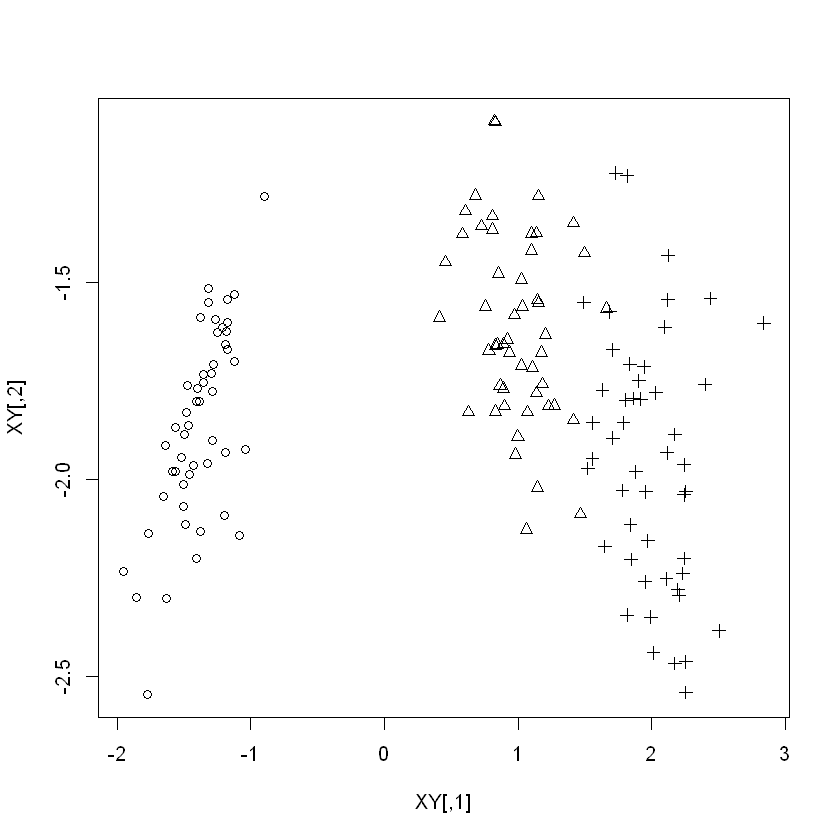

In [229]:
XY <- t(t(res$vectors[,c(1,2)]) %*% X)

plot(XY,cex=0) # silly R setting
points(XY[group == unique(group)[1],],pch=1)
points(XY[group == unique(group)[2],],pch=2)
points(XY[group == unique(group)[3],],pch=3)

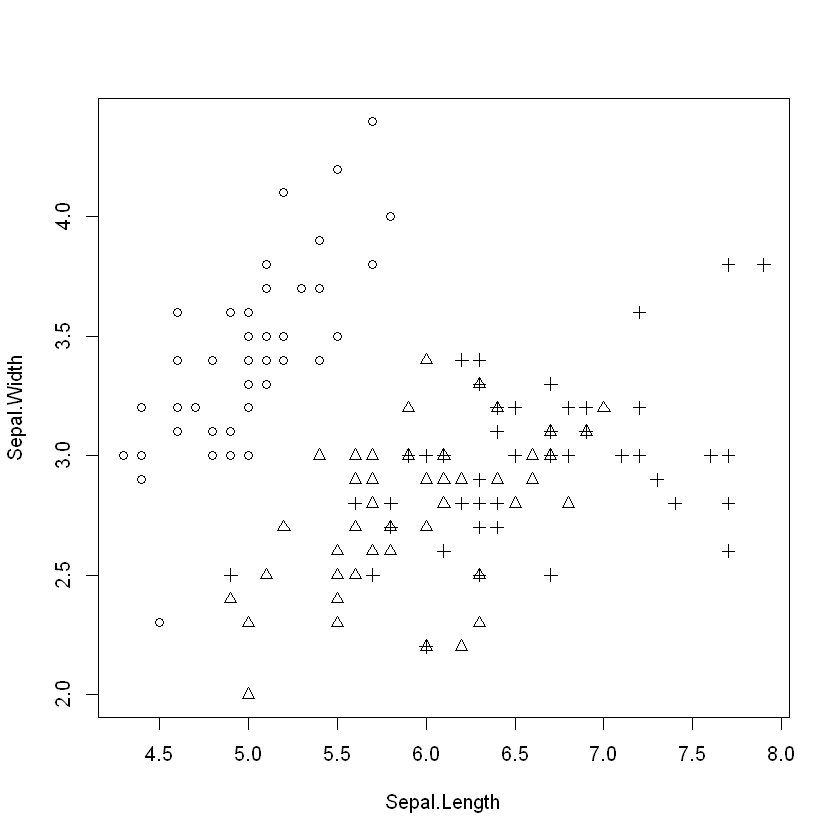

In [230]:
#XY <- t(t(res$vectors[,c(1,2)]) %*% X)
XY <- iris[,c(1,2)]

plot(XY,cex=0) # silly R setting
points(XY[group == unique(group)[1],],pch=1)
points(XY[group == unique(group)[2],],pch=2)
points(XY[group == unique(group)[3],],pch=3)

可以看出变换后和变换前（的一种组合）的混杂程度果然大大的下降了。另外也可以看出其实只要一个轴就基本已经能把它们区分开来了。正如32与0.28的区别。

### 判别执行

得出这些判别向量$a_i$后，我们用它们去作用几个分组的均值，将$p$维总体的均值投影到$r$维上（$r$为我们使用的$a$的数量）。
我们前面的处理使得我们知道这些均值投影会尽可能分开，即使甚至它们在高维空间都没有分开。

然后对于新的未知分类样本，我们直接看它也如此投影后相比那几个分组对应的中心哪个最近就判定为那个，近是直接用欧氏距离。

In [231]:
df <- iris
head(df)

Sepal.Length,Sepal.Width,Petal.Length,Petal.Width,Species
5.1,3.5,1.4,0.2,setosa
4.9,3.0,1.4,0.2,setosa
4.7,3.2,1.3,0.2,setosa
4.6,3.1,1.5,0.2,setosa
5.0,3.6,1.4,0.2,setosa
5.4,3.9,1.7,0.4,setosa


In [232]:
df[,c('X1','X2')] <- as.matrix(df[,-ncol(df)]) %*% res$vectors[,c(1,2)]

In [233]:
head(df)

Sepal.Length,Sepal.Width,Petal.Length,Petal.Width,Species,X1,X2
5.1,3.5,1.4,0.2,setosa,-1.499210,-1.886754
4.9,3.0,1.4,0.2,setosa,-1.264360,-1.592143
4.7,3.2,1.3,0.2,setosa,-1.355253,-1.733415
4.6,3.1,1.5,0.2,setosa,-1.184956,-1.623588
5.0,3.6,1.4,0.2,setosa,-1.516956,-1.944762
5.4,3.9,1.7,0.4,setosa,-1.408640,-2.201480


In [234]:
cm <- NULL
for (species in unique(df$Species)){
    cm <- rbind(cm, apply(df[df$Species == species,1:4],2,mean) %*% res$vectors[,c(1,2)])
}

In [235]:
cm

-1.3848945,-1.863640
0.9891609,-1.608068
1.9852041,-1.944303


In [236]:
pred <- NULL

for(i in 1:nrow(df)){
    score <- apply((cm - t(matrix(rep(as.matrix(df[i,c("X1","X2")]),3),2)))^2,1,sum)
    id <- which(score == min(score))
    if(length(id)>1){
        cat("warming")
    }
    pred <- c(pred,id)
}

In [237]:
pred

[1] 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 [38] 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 2 2 2
 [75] 2 2 2 2 2 2 2 2 2 3 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3
[112] 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3
[149] 3 3

In [238]:
df$predict <- pred

In [239]:
spec <- unique(df$Species)

real <- sapply(df$Species,function(name){
    which(name == spec)
})
real

[1] 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 [38] 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 [75] 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3
[112] 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
[149] 3 3

In [240]:
sum(real == pred)

[1] 147

In [241]:
sum(real == pred) / length(pred)

[1] 0.98

Fisher判别效果还不错，150个样本只错判了3个。和那个SPSS做的结果一致。

下面测试贝叶斯判别（设先验概率一样，于是就直接比较似然度了）。

In [242]:
pl <- list()

for(k in sl){
    X <- t(as.matrix(iris[iris$Species == k,-ncol(iris)]))
    mu <- apply(X,1,mean)
    sigma <- ((X - mu) %*% t(X - mu))/(nrow(X)-1)
    pl[[k]] <- list(mu = mu, sigma = sigma)
}

In [243]:
pl

,Sepal.Length,Sepal.Width,Petal.Length,Petal.Width
Sepal.Length,2.0294000,1.6205333,0.26713333,0.16873333
Sepal.Width,1.6205333,2.3469333,0.19106667,0.15186667
Petal.Length,0.2671333,0.1910667,0.49260000,0.09913333
Petal.Width,0.1687333,0.1518667,0.09913333,0.18140000
,Sepal.Length,Sepal.Width,Petal.Length,Petal.Width
Sepal.Length,4.3517333,1.391333,2.987333,0.9110667
Sepal.Width,1.3913333,1.608333,1.350000,0.6730000
Petal.Length,2.9873333,1.350000,3.606667,1.1940000
Petal.Width,0.9110667,0.673000,1.194000,0.6387333
,Sepal.Length,Sepal.Width,Petal.Length,Petal.Width


In [272]:
rm <- apply(t(as.matrix(iris[,-ncol(iris)])),2,function(x){
    #dmultinorm(x,pl[[1]]$mu,pl[[1]]$sigma)
    likelihood <- sapply(pl,function(p){
        dmultinorm(x,p$mu,p$sigma)
    })
    distance <- sapply(pl,function(p){
        t(x - p$mu) %*% solve(p$sigma) %*% (x - p$mu)
    })
    likelihood_predict <- which(likelihood == max(likelihood))
    distance_predict <- which(distance == min(distance))
    return(c(likelihood,likelihood_predict,distance,distance_predict))
})

df[,c("lk_C1","lk_C2","lk_C3","lk_predict","dis_C1","dis_C2","dis_C3","dis_predict")] <- t(rm)
df[,'real'] <- real

In [275]:
head(df[,c('real','predict','lk_predict','dis_predict')])

real,predict,lk_predict,dis_predict
1,1,1,1
1,1,1,1
1,1,1,1
1,1,1,1
1,1,1,1
1,1,1,1


In [335]:
apply(df[,c('predict','lk_predict','dis_predict')],2,function(arr){
    mean(arr == df$real)
})

predict  lk_predict dis_predict 
  0.9800000   0.9866667   0.9800000

起码在这个特例里三种判别方法效率都差不多。

In [443]:
predict.discriminant <- function(model, data, feature, decode = TRUE){
    X <- t(as.matrix(data[,feature]))
    pl <- model$pl
    fisher.a <- model$fisher.a
    fisher.kf <- model$fisher.kf
    fisher.n <- model$fisher.n
    
    fisher.rf <- fisher.a %*% X # record feature
    
    fisher.predict <- apply(fisher.rf, 2, function(rf){
        L2 <- apply((matrix(rep(rf, ncol(fisher.kf)), fisher.n) - fisher.kf)^2, 2, sum)
        return(which(L2 == min(L2)))
    })
    
    bayes.predict <- apply(X, 2, function(x){
        likelihood <- sapply(pl,function(p){
            dmultinorm(x, p$mu, p$sigma)
        })
        return(which(likelihood == max(likelihood)))
    })
    
    distance.predict <- apply(X, 2, function(x){
        distance <- sapply(pl,function(p){
            t(x - p$mu) %*% p$sigma.inv %*% (x - p$mu)
        })
        return(which(distance == min(distance)))
    })
    
    if(decode){
        fisher.predict <- sapply(fisher.predict, function(k){model$decode[[k]]})
        bayes.predict <- sapply(bayes.predict, function(k){model$decode[[k]]})
        distance.predict <- sapply(distance.predict, function(k){model$decode[[k]]})
    }
    
    return(list(fisher.predict = fisher.predict, bayes.predict = bayes.predict, distance.predict = distance.predict))
}

discriminant <- function(data, feature, group, fisher.cut = 0.95, fisher.n = NULL){
    
    X <- t(as.matrix(data[,feature]))
    gl <- unique(data[,group])
    real <- sapply(data[,group],function(g){
        which(gl == g)
    })
    rl <- unique(real)
    n <- nrow(data)
    p <- length(feature)
    
    pl <- lapply(rl,function(r){
        subX <- X[,real == r]
        mu <- apply(subX,1,mean)
        sigma <- (subX - mu) %*% t(subX - mu)  / (n-1)
        return(list(mu = mu, sigma = sigma, sigma.inv = solve(sigma)))
    })
    
    d <- decomp(X, real)
    #M <- solve(d$E) %*% d$B # this way will cause numerical problem? It some time runs well,but...
    M <- solve(d$W) %*% d$B
    res <- eigen(M)
    if(is.null(fisher.n)){
        fisher.n <- min(which(cumsum(res$values)/sum(res$values) > fisher.cut)  )
    }
    fisher.a <- t(res$vectors[,1:fisher.n])
    #fisher.rf <- fisher.a %*% X # record feature
    fisher.kf <- fisher.a %*% sapply(pl,function(p){p$mu}) # (mean) class feature

    model <- list(pl = pl, fisher.a = fisher.a, fisher.kf = fisher.kf, fisher.n = fisher.n,
                 decode = gl)
    class(model) <- 'discriminant'
    return(model)
}

In [336]:
model <- discriminant(iris, c('Sepal.Length','Sepal.Width','Petal.Length','Petal.Width' ), 'Species')

predict(model, iris, c('Sepal.Length','Sepal.Width','Petal.Length','Petal.Width' ),decode=F)

$fisher.predict
  [1] 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 [38] 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 2
 [75] 2 2 2 2 2 2 2 2 2 3 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3
[112] 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
[149] 3 3

$bayes.predict
  [1] 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 [38] 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 2 2 2
 [75] 2 2 2 2 2 2 2 2 2 3 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3
[112] 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
[149] 3 3

$distance.predict
  [1] 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 [38] 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 2 3 2
 [75] 2 2 2 2 2 2 2 2 2 3 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3
[112] 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
[149] 3 3

In [337]:
lapply(predict(model, iris, c('Sepal.Length','Sepal.Width','Petal.Length','Petal.Width' )),function(pred){
    mean(pred == iris$Species)
})

$fisher.predict
[1] 0.9866667

$bayes.predict
[1] 0.9866667

$distance.predict
[1] 0.98

In [343]:
model <- discriminant(iris, c('Sepal.Length','Sepal.Width','Petal.Length','Petal.Width' ), 'Species',fisher.n=2)

lapply(predict(model, iris, c('Sepal.Length','Sepal.Width','Petal.Length','Petal.Width' )),function(pred){
    mean(pred == iris$Species)
})



$fisher.predict
[1] 0.98

$bayes.predict
[1] 0.9866667

$distance.predict
[1] 0.98

有趣的一点是Fisher判别法只使用一个判别函数比使用两个还能多正确一个。在优化目标并不是直接为划分正确率的情况下也说明了反过拟合的必要性。

我们再分别利用这三者对总体的假设直接构造对应的样本，看看另外两个此时判别能力如何。

In [349]:
k1 <- rmultinorm(100,c(1,-1,1,-1,1),rcov(5,5))
k2 <-  rmultinorm(100,c(-1,-1,-1,-1,-1),rcov(5,5))
k3 <-  rmultinorm(100,c(3,-1,-1,-2,2),rcov(5,5))

k <- cbind(k1,k2,k3)

In [352]:
df <- data.frame(t(k))

In [354]:
df$group <- c(rep(1,100),rep(2,100),rep(3,100))

In [356]:
head(df)

X1,X2,X3,X4,X5,group
-2.8916029,-2.902262,0.6323476,1.3995561,-3.5396638,1
-0.3224974,-0.081010,-1.3497843,1.4782905,-3.0862487,1
0.5394312,2.095832,-2.1313710,1.8509769,0.4862144,1
-0.1561339,-1.654859,2.0273449,0.4444467,3.7377704,1
-1.2512918,-5.378832,2.9046856,-3.7755733,-0.2343796,1
-2.2298556,-4.325569,4.8545390,-0.2694173,-3.6357512,1


In [362]:
perm <- sample(1:300)
train <- perm[1:250]
test <- perm[251:300]

model <- discriminant(df[train,], c('X1','X2','X3','X4','X5' ), 'group')


In [368]:
lapply(predict(model, df[train,], c('X1','X2','X3','X4','X5' )),function(pred){
  mean(pred == df[train,]$group )
})

$fisher.predict
[1] 0.712

$bayes.predict
[1] 0.924

$distance.predict
[1] 0.924

In [369]:
lapply(predict(model, df[test,], c('X1','X2','X3','X4','X5' )),function(pred){
  mean(pred == df[test,]$group )
})

$fisher.predict
[1] 0.7

$bayes.predict
[1] 0.98

$distance.predict
[1] 0.98

In [385]:
k1 <- matrix(rexp(500,1),5)
k2 <- matrix(rexp(500,2),5)
k3 <- matrix(rexp(500,3),5)

A <- matrix(runif(25),5)
k <- A %*% cbind(k1,k2,k3)

df <- data.frame(t(k))
df$group <- c(rep(1,100),rep(2,100),rep(3,100))

In [386]:
cov(t(k))

2.112143,1.1036980,1.923615,1.6471977,2.166963
1.103698,0.7773182,1.047516,0.9140029,1.245098
1.923615,1.0475156,1.859194,1.6070872,1.996341
1.647198,0.9140029,1.607087,1.6574597,1.911987
2.166963,1.2450983,1.996341,1.9119874,2.485298


In [387]:
head(df)

X1,X2,X3,X4,X5,group
2.640433,1.4719307,2.7465423,2.7520528,3.100895,1
1.015351,0.6716775,0.8916166,0.9632102,1.322703,1
4.878303,1.9083695,4.2809817,3.9256200,4.518885,1
2.087606,0.4932775,1.6301839,1.3350924,1.844029,1
1.165760,1.2351997,1.4797145,2.2282558,2.257422,1
4.270935,2.1546303,3.6395632,2.5806415,4.094943,1


In [388]:
model <- discriminant(df[train,], c('X1','X2','X3','X4','X5' ), 'group')

lapply(predict(model, df[train,], c('X1','X2','X3','X4','X5' )),function(pred){
  mean(pred == df[train,]$group )
})

$fisher.predict
[1] 0.648

$bayes.predict
[1] 0.608

$distance.predict
[1] 0.528

In [389]:
lapply(predict(model, df[test,], c('X1','X2','X3','X4','X5' )),function(pred){
  mean(pred == df[test,]$group )
})

$fisher.predict
[1] 0.54

$bayes.predict
[1] 0.52

$distance.predict
[1] 0.5

很好，一旦偏离正态假设，就全都不靠谱了。不过姑且看一下Fisher判别法投影出的二维图像

In [395]:
model <- discriminant(df[train,], c('X1','X2','X3','X4','X5' ), 'group',fisher.n = 2)

In [400]:
df2 <- data.frame(t(model$fisher.a %*% k))
df2$group <- df$group
head(df2)

X1,X2,group
-2.3207343,0.0654012899,1
-0.9673992,0.0107871219,1
-3.5782781,-0.1867106147,1
-1.2258968,-0.0007397261,1
-1.6945303,0.0284690919,1
-3.1625740,0.0541920123,1


In [402]:
library(ggplot2)

Warning message:
"package 'ggplot2' was built under R version 3.3.2"

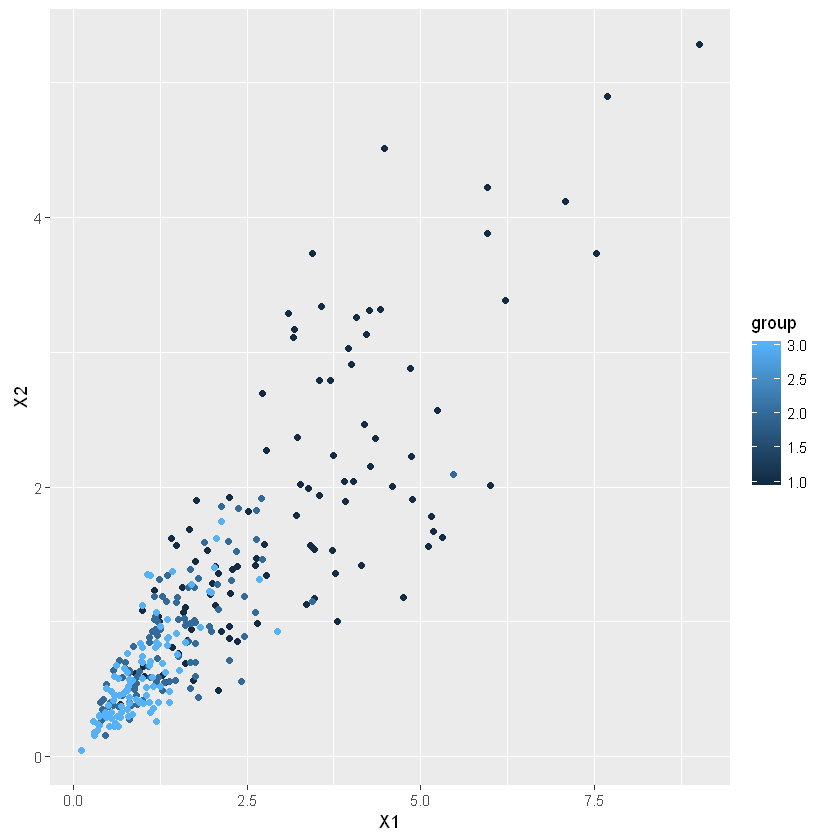

In [404]:
ggplot(df,aes(X1,X2,colour = group)) + geom_point()

看得出貌似是大期望那些吸引了大量方差导致的，是否先做标准化可能可以缓解这个问题？

In [420]:
df3 <- data.frame(scale(df[,-ncol(df)]))
df3$group <- df$group
head(df3)

X1,X2,X3,X4,X5,group
0.5181231,0.3967307,0.7151251,0.8166790,0.60999331,1
-0.6000617,-0.5109394,-0.6452674,-0.5727956,-0.51795506,1
2.0579550,0.8917521,1.8404747,1.7282416,1.50945827,1
0.1377351,-0.7132857,-0.1036061,-0.2839380,-0.18726608,1
-0.4965682,0.1282236,-0.2139595,0.4098223,0.07495881,1
1.6400375,1.1710681,1.3700618,0.6835361,1.24054153,1


In [415]:
lapply(df3,mean)

$X1
[1] 1.094611e-17

$X2
[1] 8.657336e-17

$X3
[1] 7.342831e-17

$X4
[1] -6.465098e-17

$X5
[1] 1.154758e-16

In [416]:
lapply(df3,sd)

$X1
[1] 1

$X2
[1] 1

$X3
[1] 1

$X4
[1] 1

$X5
[1] 1

In [421]:
model <- discriminant(df3[train,], c('X1','X2','X3','X4','X5' ), 'group',fisher.n = 2)

lapply(predict(model, df3[train,], c('X1','X2','X3','X4','X5' )),function(pred){
  mean(pred == df3[train,]$group )
})

$fisher.predict
[1] 0.648

$bayes.predict
[1] 0.608

$distance.predict
[1] 0.528

In [422]:
lapply(predict(model, df3[test,], c('X1','X2','X3','X4','X5' )),function(pred){
  mean(pred == df3[test,]$group )
})

$fisher.predict
[1] 0.54

$bayes.predict
[1] 0.52

$distance.predict
[1] 0.5

In [423]:
df4 <- data.frame(t(model$fisher.a %*% t(as.matrix(df3[,-ncol(df3)]))))
df4$group <- df$group
head(df4)

X1,X2,group
-0.57014546,0.049179616,1
0.60940895,0.010116280,1
-1.66620907,-0.131145970,1
0.38410482,0.001871586,1
-0.02435183,0.022763488,1
-1.30388515,0.041162067,1


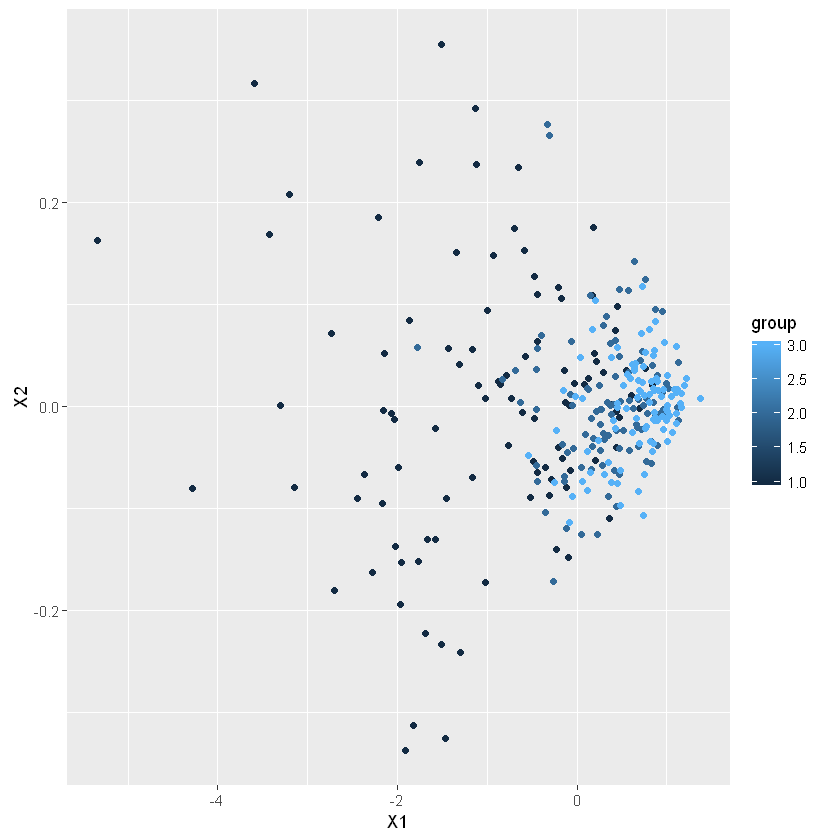

In [424]:
ggplot(df4, aes(X1,X2,colour = group)) + geom_point()

。。。应该想到这种线性变换其实没什么用，这种相对散布差异是一种更复杂的信息，不是那么好抹掉的。这也反映了这三种方法的贫乏。

In [425]:
df <- read.csv("disease.csv")

In [426]:
df

class,train,Zn,Cu,Fe,Ca,Mg,K,Na
1,1,166.0,15.80,24.50,700,112.0,179.0,513
1,1,185.0,15.70,31.50,701,125.0,184.0,427
1,1,193.0,9.80,25.90,541,163.0,128.0,642
1,1,159.0,14.20,39.70,896,99.2,239.0,726
1,1,226.0,16.20,23.80,606,152.0,70.3,218
1,1,171.0,9.29,9.29,307,187.0,45.5,257
1,1,201.0,13.30,26.60,551,101.0,49.4,141
1,1,147.0,14.50,30.00,659,102.0,154.0,680
1,1,172.0,8.85,7.86,551,75.7,98.4,318
1,1,156.0,11.50,32.50,639,107.0,103.0,552


class,train,Zn,Cu,Fe,Ca,Mg,K,Na
1,1,166.0,15.80,24.50,700,112.0,179.0,513.0
1,1,185.0,15.70,31.50,701,125.0,184.0,427.0
1,1,193.0,9.80,25.90,541,163.0,128.0,642.0
1,1,159.0,14.20,39.70,896,99.2,239.0,726.0
1,1,226.0,16.20,23.80,606,152.0,70.3,218.0
1,1,171.0,9.29,9.29,307,187.0,45.5,257.0
1,1,201.0,13.30,26.60,551,101.0,49.4,141.0
1,1,147.0,14.50,30.00,659,102.0,154.0,680.0
1,1,172.0,8.85,7.86,551,75.7,98.4,318.0
1,1,156.0,11.50,32.50,639,107.0,103.0,552.0


In [448]:
model <- discriminant(df[df$train == 1,], c('Zn','Cu','Fe','Ca','Mg','K','Na' ), 'class')

lapply(predict(model, df[df$train == 1,], c('Zn','Cu','Fe','Ca','Mg','K','Na' )),function(pred){
  mean(pred == df[df$train == 1,]$class )
})

$fisher.predict
[1] 0.9333333

$bayes.predict
[1] 0.9333333

$distance.predict
[1] 0.8833333

In [452]:
pred <- predict(model, df, c('Zn','Cu','Fe','Ca','Mg','K','Na' ))
df$fisher.predict <- pred$fisher.predict
df$bayes.predict <- pred$bayes.predict
df$distance.predict <- pred$distance.predict

In [460]:
tail(df)

,class,train,Zn,Cu,Fe,Ca,Mg,K,Na,fisher.predict,bayes.predict,distance.predict
85,NA,2,169,8.00,30.80,1068,99.1,53.0,817.0,1,1,1
86,NA,2,247,17.30,8.65,2554,241.0,77.5,373.5,2,2,2
87,NA,2,185,3.90,31.30,1211,190.0,134.0,649.8,2,2,2
88,NA,2,209,6.43,86.90,2157,288.0,74.0,219.8,2,2,2
89,NA,2,182,6.49,61.70,3870,432.0,143.0,367.5,2,2,2
90,NA,2,235,15.60,23.40,1806,166.0,68.9,188.0,2,2,2


In [461]:
model

$pl
$pl[[1]]
$pl[[1]]$mu
       Zn        Cu        Fe        Ca        Mg         K        Na 
143.10333  12.33433  23.06667 698.16667 113.39333 201.13333 526.83333 

$pl[[1]]$sigma
            Zn          Cu         Fe         Ca            Mg           K
Zn  1416.37406  31.1317554   31.86480  2982.0082   856.2023842 -1953.77904
Cu    31.13176  12.5482837   10.01260   244.3886     0.9735062   -11.94204
Fe    31.86480  10.0125989   92.92275  -125.1780   -26.6978588   -92.10420
Ca  2982.00819 244.3886158 -125.17802 35884.1384  2679.5802260 -4570.79605
Mg   856.20238   0.9735062  -26.69786  2679.5802  1078.6789605 -1795.59192
K  -1953.77904 -11.9420395  -92.10420 -4570.7960 -1795.5919209 33171.57537
Na -1911.36412  85.9462994  280.77362  3625.7938 -1316.4225989 29142.82147
           Na
Zn -1911.3641
Cu    85.9463
Fe   280.7736
Ca  3625.7938
Mg -1316.4226
K  29142.8215
Na 44409.5960

$pl[[1]]$sigma.inv
              Zn            Cu            Fe            Ca            Mg
Zn  1.669667